# **Taller - Análisis de Componentes Principales**
**Universidad de la Sabana - Analítica de Datos**

***Jorge Esteban Diaz Bernal, Laura Camila rodriguez Leon, Carlos Augusto Sanchez Lombana***

### **Sección 1: Definición del problema y el Dataset**

In [173]:
import zipfile
from pathlib import Path
import pandas as pd

# 1. Definir rutas base
BASE_DIR = Path().resolve()
ZIP_DIR = BASE_DIR / "datos_zip"
EXTRAIDOS_DIR = BASE_DIR / "datos_extraidos"

# 2. Detectar ZIPs
zips = list(ZIP_DIR.glob("*.zip"))
print(f"Se encontraron {len(zips)} archivos ZIP en '{ZIP_DIR.name}'.")

# 3. Extraer si es necesario
for zip_path in zips:
    nombre_limpio = zip_path.stem.strip().replace(" ", "_").replace("__", "_").replace("1", "")
    destino = EXTRAIDOS_DIR / nombre_limpio

    if not destino.exists():
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destino)
        print(f"✅ Extraído: {nombre_limpio}")
    else:
        print(f"🟡 Ya extraído: {nombre_limpio}")


# 4. Cargar CSVs detectando carpetas "CSV/" anidadas
datos = {}

for mes_dir in EXTRAIDOS_DIR.iterdir():
    if not mes_dir.is_dir():
        continue

    mes = mes_dir.name
    carpeta_csv = None

    # Buscar la carpeta "CSV" más profunda con archivos CSV dentro
    for subdir in mes_dir.rglob("CSV"):
        csvs = list(subdir.glob("*.csv"))
        if csvs:
            carpeta_csv = subdir
            break

    if carpeta_csv:
        archivos = list(carpeta_csv.glob("*.csv"))
        datos[mes] = {
            f.stem.strip(): pd.read_csv(f, encoding="latin1", sep=";", low_memory=False)
            for f in archivos
        }
        print(f"📁 {mes}: {len(datos[mes])} tablas cargadas")
    else:
        print(f"⚠️ No se encontraron archivos CSV en: {mes_dir}")


Se encontraron 4 archivos ZIP en 'datos_zip'.
🟡 Ya extraído: Diciembre_2024
🟡 Ya extraído: Febrero_2024
🟡 Ya extraído: Julio_2024
🟡 Ya extraído: Septiembre_2024
📁 Diciembre_2024: 8 tablas cargadas
📁 Febrero_2024: 8 tablas cargadas
📁 Julio_2024: 8 tablas cargadas
📁 Septiembre_2024: 8 tablas cargadas


FEBRERO

In [174]:
mes_febrero = datos["Febrero_2024"]
febrero_ocupados = mes_febrero["Ocupados"]
febrero_otras_formas_de_trabajo = mes_febrero["Otras formas de trabajo"]
febrero_caracteristicas_generales = mes_febrero["Características generales, seguridad social en salud y educación"]
febrero_datos_del_hogar = mes_febrero["Datos del hogar y la vivienda"]
febrero_migracion = mes_febrero["Migración"]
febrero_otros_ingresos_e_impuestos = mes_febrero["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
febrero_otras_formas_de_trabajo = limpiar(febrero_otras_formas_de_trabajo)
febrero_caracteristicas_generales = limpiar(febrero_caracteristicas_generales)
febrero_migracion = limpiar(febrero_migracion)
febrero_otros_ingresos_e_impuestos = limpiar(febrero_otros_ingresos_e_impuestos)

df_merged2 = febrero_ocupados.merge(febrero_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_caracteristicas_generales, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_migracion, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged2.shape  # Número de filas y columnas
df_merged2.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29943 entries, 0 to 29942
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 109.4+ MB


JULIO

In [175]:
mes_julio = datos["Julio_2024"]
julio_ocupados = mes_julio["Ocupados"]
julio_otras_formas_de_trabajo = mes_julio["Otras formas de trabajo"]
julio_caracteristicas_generales = mes_julio["Características generales, seguridad social en salud y educación"]
julio_datos_del_hogar = mes_julio["Datos del hogar y la vivienda"]
julio_migracion = mes_julio["Migración"]
julio_otros_ingresos_e_impuestos = mes_julio["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
julio_otras_formas_de_trabajo = limpiar(julio_otras_formas_de_trabajo)
julio_caracteristicas_generales = limpiar(julio_caracteristicas_generales)
julio_migracion = limpiar(julio_migracion)
julio_otros_ingresos_e_impuestos = limpiar(julio_otros_ingresos_e_impuestos)

df_merged7 = julio_ocupados.merge(julio_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_caracteristicas_generales, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_migracion, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged7.shape  # Número de filas y columnas
df_merged7.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29929 entries, 0 to 29928
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 109.4+ MB


SEPTIEMBRE

In [176]:
mes_septiembre = datos["Septiembre_2024"]
septiembre_ocupados = mes_septiembre["Ocupados"]
septiembre_otras_formas_de_trabajo = mes_septiembre["Otras formas de trabajo"]
septiembre_caracteristicas_generales = mes_septiembre["Características generales, seguridad social en salud y educación"]
septiembre_datos_del_hogar = mes_septiembre["Datos del hogar y la vivienda"]
septiembre_migracion = mes_septiembre["Migración"]
septiembre_otros_ingresos_e_impuestos = mes_septiembre["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
septiembre_otras_formas_de_trabajo = limpiar(septiembre_otras_formas_de_trabajo)
septiembre_caracteristicas_generales = limpiar(septiembre_caracteristicas_generales)
septiembre_migracion = limpiar(septiembre_migracion)
septiembre_otros_ingresos_e_impuestos = limpiar(septiembre_otros_ingresos_e_impuestos)

df_merged9 = septiembre_ocupados.merge(septiembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_migracion, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged9.shape  # Número de filas y columnas
df_merged9.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29383 entries, 0 to 29382
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 107.4+ MB


DICIEMBRE

In [177]:
# DICIEMBRE
mes_diciembre = datos["Diciembre_2024"]
diciembre_ocupados = mes_diciembre["Ocupados"]
diciembre_otras_formas_de_trabajo = mes_diciembre["Otras formas de trabajo"]
diciembre_caracteristicas_generales = mes_diciembre["Características generales, seguridad social en salud y educación"]
diciembre_datos_del_hogar = mes_diciembre["Datos del hogar y la vivienda"]
diciembre_migracion = mes_diciembre["Migración"]
diciembre_otros_ingresos_e_impuestos = mes_diciembre["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
diciembre_otras_formas_de_trabajo = limpiar(diciembre_otras_formas_de_trabajo)
diciembre_caracteristicas_generales = limpiar(diciembre_caracteristicas_generales)
diciembre_migracion = limpiar(diciembre_migracion)
diciembre_otros_ingresos_e_impuestos = limpiar(diciembre_otros_ingresos_e_impuestos)

df_merged12 = diciembre_ocupados.merge(diciembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_migracion, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged12.shape  # Número de filas y columnas
df_merged12.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28154 entries, 0 to 28153
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 102.9+ MB


In [178]:
variables_faltantes = [
    'P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5',
    'P5050', 'P5090', 'P5110', 'P5140', 'P6008', 'P6240', 'P7250'
]

dfs = [df_merged12, df_merged9, df_merged7, df_merged2]
nombres_dfs = ['df_merged12', 'df_merged9', 'df_merged7', 'df_merged2']

for name, df in zip(nombres_dfs, dfs):
    presentes = [var for var in variables_faltantes if var in df.columns]
    print(f"✅ {name} contiene {len(presentes)} de 14 esperadas: {presentes}")


✅ df_merged12 contiene 12 de 14 esperadas: ['P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5', 'P5050', 'P5090', 'P5110', 'P5140', 'P6008']
✅ df_merged9 contiene 12 de 14 esperadas: ['P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5', 'P5050', 'P5090', 'P5110', 'P5140', 'P6008']
✅ df_merged7 contiene 12 de 14 esperadas: ['P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5', 'P5050', 'P5090', 'P5110', 'P5140', 'P6008']
✅ df_merged2 contiene 12 de 14 esperadas: ['P4000', 'P4030S1', 'P4030S1A1', 'P4030S2', 'P4030S3', 'P4030S4', 'P4030S5', 'P5050', 'P5090', 'P5110', 'P5140', 'P6008']


ANUAL

In [179]:
import pandas as pd

# Lista de tus dataframes
dfs = [df_merged12, df_merged9, df_merged7, df_merged2]

# Concatenar, ignorando los índices originales y creando uno nuevo
df_total = pd.concat(dfs, ignore_index=True)

# Opcional: comprobar que no hayas duplicado filas
df_total.drop_duplicates(inplace=True)

# Opcional: resetear índice tras el drop_duplicates
df_total.reset_index(drop=True, inplace=True)

# Revisa el resultado
print(df_total.shape)
print(df_total.head())


(117409, 479)
   PERIODO_x  MES_x  PER_x  DIRECTORIO  SECUENCIA_P  ORDEN  HOGAR_x  REGIS_x  \
0   20241252     12   2024     8038184            1      1        1       60   
1   20241252     12   2024     8038186            1      2        1       60   
2   20241252     12   2024     8038187            1      1        1       60   
3   20241252     12   2024     8038188            1      2        1       60   
4   20241252     12   2024     8038189            1      1        1       60   

   AREA_x  CLASE_x  ...  P5222S3  P5222S4  P5222S5  P5222S6  P5222S7  P5222S8  \
0     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
1     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
2     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
3     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
4     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   

   P5222S9  P5222S

Tratamiento de los datos

In [180]:
import numpy as np

# 1) Diccionario de renombres
nombres_variables = {
    "P6040": "EDAD",
    "P3271": "SEXO_NACIMIENTO",
    "P3039": "GENERO",
    "P3038": "ATRACCION_POR",
    "P6080": "ETNIA",
    "P6080S1": "GRUPO_INDIGENA",
    "CLASE": "URBANO_RURAL",
    "P6160": "SABE_LEER",
    "P6170": "ACTUALMENTE_ESTUDIA",
    "P3041": "ACTUALMENTE_INSTITUCION",
    "P3042": "MAXIMO_NIVEL_EDUCATIVO",
    "P6500": "INGRESO",
    "OFICIO_C8": "OCUPACION",
    "P6800": "HORAS_TRABAJO",
    "P6430": "POSICION_OCUPACIONAL",
    "P6440": "EXISTENCIA_CONTRATO",
    "P6450": "CONTRATO_VERBAL_ESCRITO",
    "P6460": "TERMINO_CONTRATO",
    "RAMA2D_R4": "SECTOR_AMPLIO",
    "RAMA4D_R4": "SECTOR_DETALLADO",
    "P6008": "TOTAL_PERSONAS_HOGAR",
    "P6070": "ESTADO_CIVIL",
    "P6050": "PARENTESCO_CON_JEFE_HOGAR",
    "P4000": "TIPO_VIVIENDA",
    "P4030S1A1": "ESTRATO",
    "P5090": "TENENCIA_VIVIENDA",
    "P4030S1": "ELECTRICIDAD",
    "P4030S2": "GAS_NATURAL",
    "P4030S3": "ALCANTARILLADO",
    "P4030S5": "ACUEDUCTO",
    "P5050": "AGUA_POTABLE",
    "P5110": "VALOR_VIVIENDA",
    "P5140": "VALOR_ARRIENDO",
    "P3077S1A2": "LIMPIEZA_EN_SU_HOGAR_HORAS_DIA",
    "P3079S1A2": "CUIDADO_NINOS_SU_HOGAR_HORAS_DIA",
    "P3081S1A2": "CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA"
}

# 2) Columnas deseadas en el subset (sin ACTIVIDAD_MAYOR_TIEMPO)
cols_ingreso = [
    'DIRECTORIO', 'SECUENCIA_P', 'ORDEN',
    'INGRESO', 'FT', 'EDAD', 'SEXO_NACIMIENTO', 'GENERO', 'ATRACCION_POR',
    'ETNIA', 'CAMPESINO', 'ESTRATO', 'TIPO_VIVIENDA', 'TENENCIA_VIVIENDA',
    'URBANO_RURAL', 'ELECTRICIDAD', 'GAS_NATURAL', 'DPTO', 'ACUEDUCTO',
    'ALCANTARILLADO','AGUA_POTABLE', 'TOTAL_PERSONAS_HOGAR',
    'MAXIMO_NIVEL_EDUCATIVO', 'SABE_LEER', 'ENTIDAD_SEGURIDAD_SOCIAL_SALUD',
    'OCUPACION', 'HORAS_TRABAJO', 'POSICION_OCUPACIONAL', 'EXISTENCIA_CONTRATO',
    'CONTRATO_VERBAL_ESCRITO', 'TERMINO_CONTRATO', 'CONFORME_TIPO_CONTRATO',
    'CESANTIA','LICENCIA_ENFERMEDAD_PAGADA',
    'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL','PRIMA_SERVICIOS','SECTOR_AMPLIO',
    'SECTOR_DETALLADO','ACTUALMENTE_ESTUDIA',
    'GRUPO_INDIGENA','LIMPIEZA_EN_SU_HOGAR','CUIDADO_NINOS_SU_HOGAR',
    'CUIDADO_MAYORES_SU_HOGAR','APOYO_TAREAS_SU_HOGAR',
    'LIMPIEZA_EN_SU_HOGAR_DIAS','LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_DIAS','CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_DIAS','CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'
]

# 3) Limpiar sufijos de merge (_x / _y)
df_total.columns = df_total.columns.str.replace(r'(_x|_y)$', '', regex=True)

# 4) Renombrar según el diccionario
df_total = df_total.rename(columns=nombres_variables)

# 5) Añadir cualquier columna faltante como NaN
for c in cols_ingreso:
    if c not in df_total.columns:
        df_total[c] = np.nan

# 6) Crear el subset final
df = df_total[cols_ingreso]

# 7) Verificar
print("df tamaño:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


df tamaño: (117409, 52)
Columns: ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'INGRESO', 'FT', 'EDAD', 'SEXO_NACIMIENTO', 'GENERO', 'ATRACCION_POR', 'ETNIA', 'CAMPESINO', 'ESTRATO', 'TIPO_VIVIENDA', 'TENENCIA_VIVIENDA', 'URBANO_RURAL', 'URBANO_RURAL', 'ELECTRICIDAD', 'GAS_NATURAL', 'DPTO', 'DPTO', 'ACUEDUCTO', 'ALCANTARILLADO', 'AGUA_POTABLE', 'TOTAL_PERSONAS_HOGAR', 'MAXIMO_NIVEL_EDUCATIVO', 'SABE_LEER', 'ENTIDAD_SEGURIDAD_SOCIAL_SALUD', 'OCUPACION', 'HORAS_TRABAJO', 'POSICION_OCUPACIONAL', 'EXISTENCIA_CONTRATO', 'CONTRATO_VERBAL_ESCRITO', 'TERMINO_CONTRATO', 'CONFORME_TIPO_CONTRATO', 'CESANTIA', 'LICENCIA_ENFERMEDAD_PAGADA', 'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL', 'PRIMA_SERVICIOS', 'SECTOR_AMPLIO', 'SECTOR_DETALLADO', 'ACTUALMENTE_ESTUDIA', 'GRUPO_INDIGENA', 'LIMPIEZA_EN_SU_HOGAR', 'CUIDADO_NINOS_SU_HOGAR', 'CUIDADO_MAYORES_SU_HOGAR', 'APOYO_TAREAS_SU_HOGAR', 'LIMPIEZA_EN_SU_HOGAR_DIAS', 'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA', 'CUIDADO_MAYORES_SU_HOGAR_DIAS', 'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA', '

,DIRECTORIO,SECUENCIA_P,ORDEN,INGRESO,FT,EDAD,SEXO_NACIMIENTO,GENERO,ATRACCION_POR,ETNIA,...,LIMPIEZA_EN_SU_HOGAR,CUIDADO_NINOS_SU_HOGAR,CUIDADO_MAYORES_SU_HOGAR,APOYO_TAREAS_SU_HOGAR,LIMPIEZA_EN_SU_HOGAR_DIAS,LIMPIEZA_EN_SU_HOGAR_HORAS_DIA,CUIDADO_MAYORES_SU_HOGAR_DIAS,CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA,CUIDADO_NINOS_SU_HOGAR_DIAS,CUIDADO_NINOS_SU_HOGAR_HORAS_DIA
0,8038184,1,1,NaN,1,50,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8038186,1,2,NaN,1,32,2,2.0,1.0,6,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,8038187,1,1,1300000.0,1,63,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8038188,1,2,2800000.0,1,31,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8038189,1,1,1300000.0,1,33,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
# Opción A: usando .dropna()
df_final = df.dropna(subset=['INGRESO']).copy()

# Verifica
print("Antes:", df.shape)
print("Después:", df_final.shape)
display(df_final.head())


Antes: (117409, 52)
Después: (60341, 52)


,DIRECTORIO,SECUENCIA_P,ORDEN,INGRESO,FT,EDAD,SEXO_NACIMIENTO,GENERO,ATRACCION_POR,ETNIA,...,LIMPIEZA_EN_SU_HOGAR,CUIDADO_NINOS_SU_HOGAR,CUIDADO_MAYORES_SU_HOGAR,APOYO_TAREAS_SU_HOGAR,LIMPIEZA_EN_SU_HOGAR_DIAS,LIMPIEZA_EN_SU_HOGAR_HORAS_DIA,CUIDADO_MAYORES_SU_HOGAR_DIAS,CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA,CUIDADO_NINOS_SU_HOGAR_DIAS,CUIDADO_NINOS_SU_HOGAR_HORAS_DIA
2,8038187,1,1,1300000.0,1,63,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8038188,1,2,2800000.0,1,31,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8038189,1,1,1300000.0,1,33,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8038191,1,1,1300000.0,1,42,2,2.0,1.0,6,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
6,8038192,1,1,1300000.0,1,36,1,1.0,2.0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
# Total de filas del DataFrame
total_filas = len(df_final)

# Conteo absoluto de nulos
nulos_abs = df_final.isna().sum()

# Porcentaje de nulos por columna
nulos_pct = (nulos_abs / total_filas * 100).round(2)

# DataFrame resumen
nulos_df = pd.DataFrame({
    'nulos': nulos_abs,
    'porcentaje': nulos_pct
})

# Filtrar columnas que tienen al menos un NaN
nulos_df = nulos_df[nulos_df['nulos'] > 0]

# Ordenar de mayor a menor porcentaje
nulos_df = nulos_df.sort_values(by='porcentaje', ascending=False)

# Mostrar resultado
print("Valores nulos por columna (ordenados por porcentaje):")
print(nulos_df)


Valores nulos por columna (ordenados por porcentaje):
                                    nulos  porcentaje
ENTIDAD_SEGURIDAD_SOCIAL_SALUD      60341      100.00
CAMPESINO                           60341      100.00
TIEMPO_TRABAJANDO_EMPRESA_ACTUAL    60341      100.00
LICENCIA_ENFERMEDAD_PAGADA          60341      100.00
CESANTIA                            60341      100.00
CONFORME_TIPO_CONTRATO              60341      100.00
CUIDADO_NINOS_SU_HOGAR_DIAS         60341      100.00
APOYO_TAREAS_SU_HOGAR               60341      100.00
LIMPIEZA_EN_SU_HOGAR_DIAS           60341      100.00
CUIDADO_MAYORES_SU_HOGAR_DIAS       60341      100.00
PRIMA_SERVICIOS                     60341      100.00
LIMPIEZA_EN_SU_HOGAR                60341      100.00
CUIDADO_NINOS_SU_HOGAR              60341      100.00
CUIDADO_MAYORES_SU_HOGAR            60341      100.00
CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA  59237       98.17
GRUPO_INDIGENA                      58734       97.34
CUIDADO_NINOS_SU_HOGAR_HORAS

In [183]:
# 1) Rellenar NaN en TERMINO_CONTRATO y ESTRATO con 9
df_final[['TERMINO_CONTRATO', 'ESTRATO']] = (
    df_final[['TERMINO_CONTRATO', 'ESTRATO']]
    .fillna(9)
)

# 2) Eliminar filas que carezcan de GENERO o ATRACCION_POR
df_final = df_final.dropna(subset=['GENERO', 'ATRACCION_POR'])

# 3) Asumir GRUPO_INDIGENA = 0 cuando falte
df_final['GRUPO_INDIGENA'] = df_final['GRUPO_INDIGENA'].fillna(0)

# 4) Para cada actividad del hogar: si indicador == 2 y días es NaN, poner días=0 y horas=0
actividades = [
    'LIMPIEZA_EN_SU_HOGAR',
    'CUIDADO_MAYORES_SU_HOGAR',
    'CUIDADO_NINOS_SU_HOGAR',
    'APOYO_TAREAS_SU_HOGAR'
]

for act in actividades:
    dias_col  = f"{act}_DIAS"
    horas_col = f"{act}_HORAS_DIA"

    # Sólo procedemos si la columna de "días" existe
    if dias_col in df_final.columns:
        # Condición: no realiza la actividad (==2) y días es NaN
        mask = (df_final[act] == 2) & df_final[dias_col].isna()
        df_final.loc[mask, dias_col] = 0

        # Si además existe la columna de horas, la rellenamos también
        if horas_col in df_final.columns:
            df_final.loc[mask, horas_col] = 0

# 5) Verificar el resultado
df_final.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 59981 entries, 2 to 117408
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DIRECTORIO                          59981 non-null  int64  
 1   SECUENCIA_P                         59981 non-null  int64  
 2   ORDEN                               59981 non-null  int64  
 3   INGRESO                             59981 non-null  float64
 4   FT                                  59981 non-null  int64  
 5   EDAD                                59981 non-null  int64  
 6   SEXO_NACIMIENTO                     59981 non-null  int64  
 7   GENERO                              59981 non-null  float64
 8   ATRACCION_POR                       59981 non-null  float64
 9   ETNIA                               59981 non-null  int64  
 10  CAMPESINO                           0 non-null      float64
 11  ESTRATO                             59981 non

### **Sección 2: Analisis Exploratorio de Datos (EDA)**

=== DESCRIPTIVOS POR GÉNERO ===
                mean     median  count
GENERO                                
1.0     1.953647e+06  1300000.0  31611
2.0     1.823504e+06  1300000.0  28335
3.0     2.443429e+06  1300000.0     28
4.0     1.885714e+06  1500000.0      7 

t-test Género: t = -7.94, p = 0.000

=== RESUMEN REGRESIÓN BRECHA DE GÉNERO ===
                            OLS Regression Results                            
Dep. Variable:                INGRESO   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     1.537
Date:                Sun, 25 May 2025   Prob (F-statistic):              0.108
Time:                        19:00:21   Log-Likelihood:                -1030.1
No. Observations:                  68   AIC:                             2126.
Df Residuals:                      35   BIC:                             2199.
Df Model:           

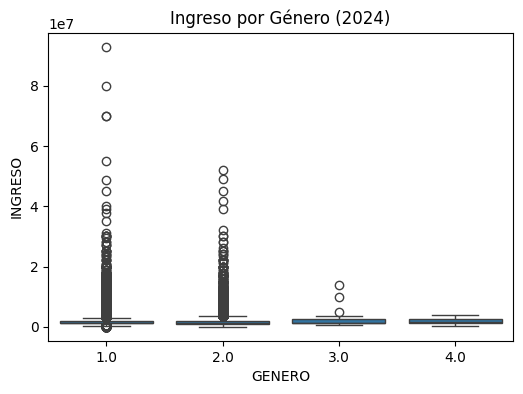

=== MEDIA DE INGRESO POR ETNIA ===
ETNIA
2    1.321667e+06
4    1.386500e+06
1    1.449678e+06
5    1.628553e+06
6    1.925563e+06
3    2.068292e+06
Name: INGRESO, dtype: float64 

ANOVA Étnico → F = 33.03, p = 0.000



C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_11408\2637107956.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('ETNIA')['INGRESO'].mean().sort_values(), "\n")
C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_11408\2637107956.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  F_e, p_e = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('ETNIA')])


=== RESULTADOS TUKEY POST-HOC ===
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj      lower        upper     reject
-------------------------------------------------------------------
     1      2 -128010.9514    1.0 -2480686.6444 2224664.7416  False
     1      3  618614.0486 0.0022   151899.2856 1085328.8116   True
     1      4  -63177.6181    1.0 -1887843.2291  1761487.993  False
     1      5  178874.9881 0.0316     9340.0798  348409.8964   True
     1      6  475885.2224    0.0   329257.1813  622513.2634   True
     2      3     746625.0  0.949 -1643172.3504 3136422.3504  False
     2      4   64833.3333    1.0   -2905471.92 3035138.5867  False
     2      5  306885.9395 0.9991 -2043018.4822 2656790.3611  False
     2      6  603896.1738 0.9779 -1744466.7642 2952259.1117  False
     3      4 -681791.6667 0.9053 -2554077.1821 1190493.8488  False
     3      5 -439739.0605 0.0625  -892276.9534   12798.8323  False
     3      6 

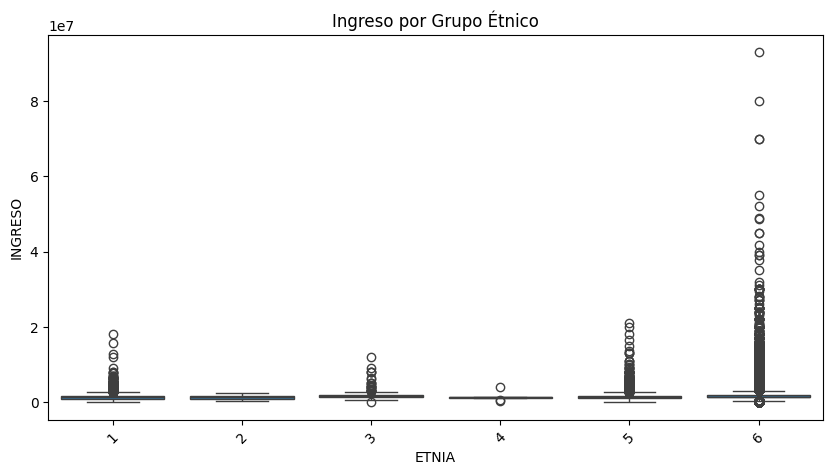

=== INGRESO PROMEDIO POR DPTO ===
DPTO
81    1.442634e+06
20    1.556403e+06
70    1.626981e+06
73    1.628301e+06
27    1.657061e+06
47    1.668670e+06
52    1.694709e+06
25    1.719283e+06
23    1.729590e+06
44    1.751934e+06
63    1.769417e+06
88    1.771482e+06
76    1.777674e+06
18    1.780827e+06
19    1.784331e+06
13    1.840205e+06
8     1.861602e+06
50    1.877612e+06
66    1.954522e+06
17    1.965702e+06
68    1.969370e+06
41    1.979307e+06
54    1.987343e+06
15    2.020568e+06
99    2.046036e+06
5     2.109020e+06
94    2.131878e+06
85    2.137866e+06
91    2.143819e+06
95    2.202225e+06
97    2.588470e+06
11    2.667090e+06
86    2.865379e+06
Name: INGRESO, dtype: float64 

ANOVA Regional → F = 26.21, p = 0.000



C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_11408\2637107956.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dept_means = df.groupby('DPTO')['INGRESO'].mean().sort_values()
C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_11408\2637107956.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  F_r, p_r = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('DPTO')])


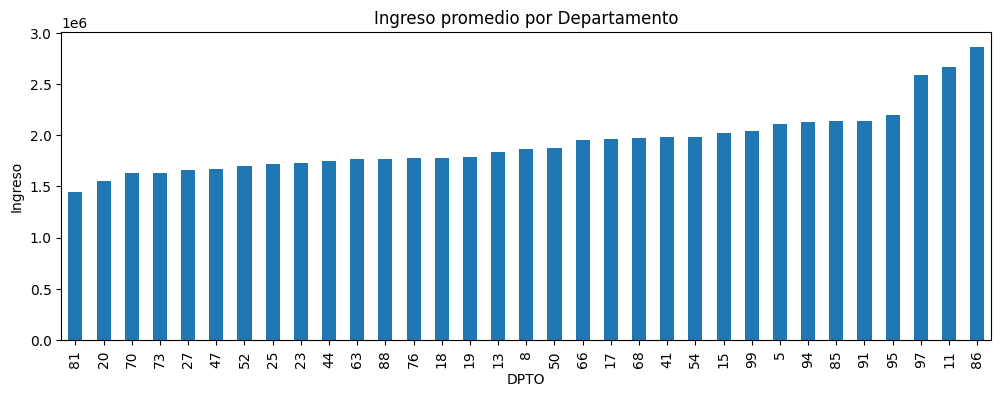

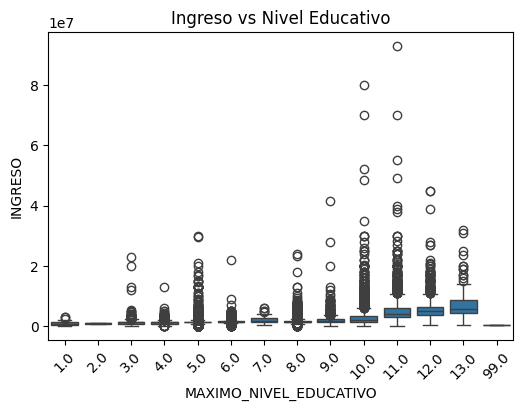

=== COEFICIENTES REGRESIÓN EDUCACIÓN ===
Intercept                           -1.962474e+05
C(MAXIMO_NIVEL_EDUCATIVO)[T.2.0]     4.298205e+04
C(MAXIMO_NIVEL_EDUCATIVO)[T.3.0]     3.513718e+05
C(MAXIMO_NIVEL_EDUCATIVO)[T.4.0]     6.213259e+05
C(MAXIMO_NIVEL_EDUCATIVO)[T.5.0]     9.253901e+05
C(MAXIMO_NIVEL_EDUCATIVO)[T.6.0]     1.050080e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.7.0]     1.614551e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.8.0]     1.258071e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.9.0]     1.487767e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.10.0]    2.328539e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.11.0]    4.545325e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.12.0]    5.065795e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.13.0]    6.535245e+06
C(MAXIMO_NIVEL_EDUCATIVO)[T.99.0]   -1.767878e+05
C(GENERO)[T.2.0]                    -3.899492e+05
C(GENERO)[T.3.0]                     3.001298e+05
C(GENERO)[T.4.0]                    -3.359038e+05
EDAD                                 2.084283e+04
dtype: float64 

=== INGRESO POR SECTOR_AMPLIO ===
=== INGR

C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_11408\2637107956.py:109: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('EXISTENCIA_CONTRATO')['INGRESO'].mean().sort_values(), "\n")


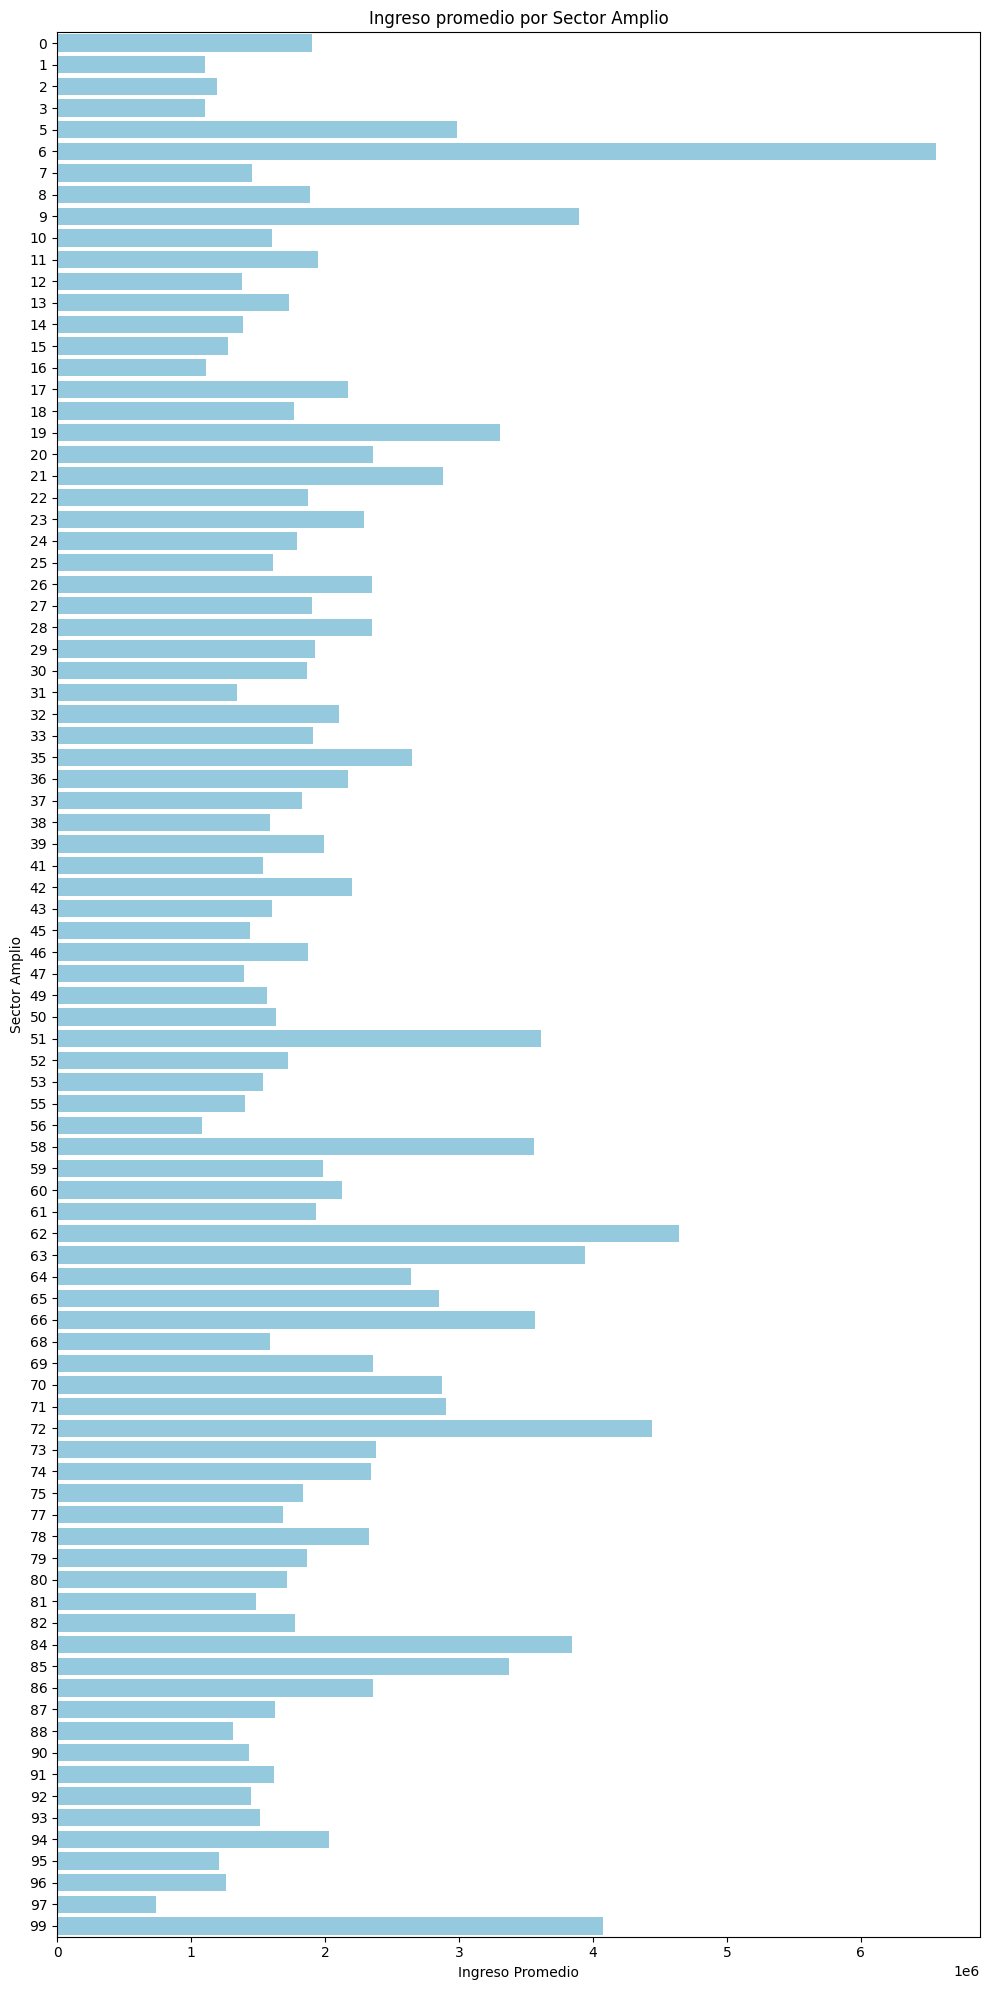

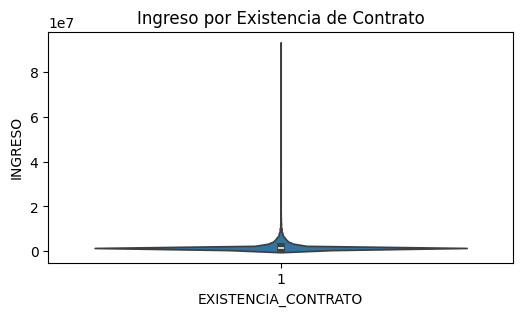

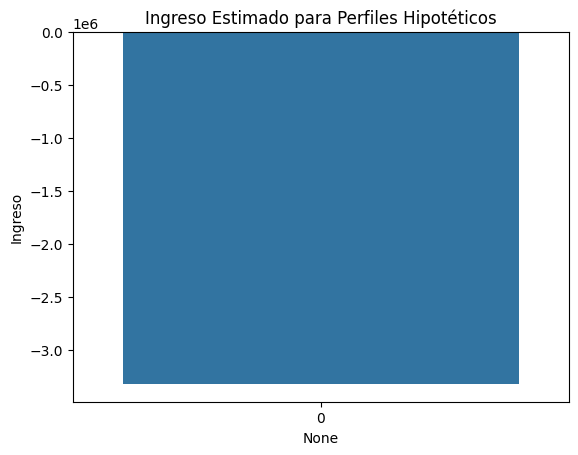

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Partimos de tu DataFrame final
df = df_final.copy()

# 1) Elimina posibles columnas duplicadas
df = df.loc[:, ~df.columns.duplicated()]

# 2) Renombra DPTO_x si lo necesitas y crea una única columna DPTO
if 'DPTO_x' in df.columns:
    df = df.rename(columns={'DPTO_x':'DPTO'})
elif 'DPTO' not in df.columns:
    raise KeyError("No se encontró ninguna columna DPTO_x ni DPTO en df_final")

# 3) Convierte a categóricas las variables que lo requieran
for col in ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO','SECTOR_AMPLIO','EXISTENCIA_CONTRATO']:
    if col in df.columns:
        df[col] = df[col].astype('category')

# -----------------------------------------------------------------------------
# 1) BRECHA DE GÉNERO
# -----------------------------------------------------------------------------
print("=== DESCRIPTIVOS POR GÉNERO ===")
print(df.groupby('GENERO', observed=True)['INGRESO'].agg(['mean','median','count']), "\n")

# T-test Hombres vs Mujeres (ajusta códigos si no son 1 y 2)
df_m = df[df.GENERO == df.GENERO.cat.categories[1]]['INGRESO']
df_f = df[df.GENERO == df.GENERO.cat.categories[0]]['INGRESO']
t, p = stats.ttest_ind(df_m, df_f, equal_var=False)
print(f"t-test Género: t = {t:.2f}, p = {p:.3f}\n")

mod_gen = smf.ols(
    "INGRESO ~ C(GENERO) + EDAD + HORAS_TRABAJO "
    "+ LIMPIEZA_EN_SU_HOGAR_HORAS_DIA + CUIDADO_NINOS_SU_HOGAR_HORAS_DIA "
    "+ CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA + C(ETNIA) + C(DPTO)",
    data=df
).fit()
print("=== RESUMEN REGRESIÓN BRECHA DE GÉNERO ===")
print(mod_gen.summary(), "\n")

plt.figure(figsize=(6,4))
sns.boxplot(x='GENERO', y='INGRESO', data=df)
plt.title("Ingreso por Género (2024)")
plt.show()

# -----------------------------------------------------------------------------
# 2) DISPARIDADES ÉTNICAS
# -----------------------------------------------------------------------------
print("=== MEDIA DE INGRESO POR ETNIA ===")
print(df.groupby('ETNIA')['INGRESO'].mean().sort_values(), "\n")

F_e, p_e = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('ETNIA')])
print(f"ANOVA Étnico → F = {F_e:.2f}, p = {p_e:.3f}\n")

tukey = pairwise_tukeyhsd(df['INGRESO'], df['ETNIA'], alpha=0.05)
print("=== RESULTADOS TUKEY POST-HOC ===")
print(tukey.summary(), "\n")

plt.figure(figsize=(10,5))
sns.boxplot(x='ETNIA', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso por Grupo Étnico")
plt.show()

# -----------------------------------------------------------------------------
# 3) DIFERENCIAS REGIONALES
# -----------------------------------------------------------------------------
print("=== INGRESO PROMEDIO POR DPTO ===")
dept_means = df.groupby('DPTO')['INGRESO'].mean().sort_values()
print(dept_means, "\n")

F_r, p_r = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('DPTO')])
print(f"ANOVA Regional → F = {F_r:.2f}, p = {p_r:.3f}\n")

dept_means.plot(kind='bar', figsize=(12,4), title="Ingreso promedio por Departamento")
plt.ylabel("Ingreso")
plt.show()

# -----------------------------------------------------------------------------
# 4) IMPACTO EDUCATIVO
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x='MAXIMO_NIVEL_EDUCATIVO', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso vs Nivel Educativo")
plt.show()

mod_edu = smf.ols(
    "INGRESO ~ C(MAXIMO_NIVEL_EDUCATIVO) + EDAD + C(GENERO)",
    data=df
).fit()
print("=== COEFICIENTES REGRESIÓN EDUCACIÓN ===")
print(mod_edu.params, "\n")

# -----------------------------------------------------------------------------
# 5) PRIMAS OCUPACIONALES
# -----------------------------------------------------------------------------
print("=== INGRESO POR SECTOR_AMPLIO ===")
plt.figure(figsize=(10, 20))  # más alto que ancho
sector_mean = df.groupby('SECTOR_AMPLIO', observed=True)['INGRESO'].mean().sort_values()

print("=== INGRESO POR EXISTENCIA_CONTRATO ===")
print(df.groupby('EXISTENCIA_CONTRATO')['INGRESO'].mean().sort_values(), "\n")



sns.barplot(x=sector_mean.values, y=sector_mean.index, orient='h', color='skyblue')
plt.xlabel("Ingreso Promedio")
plt.ylabel("Sector Amplio")
plt.title("Ingreso promedio por Sector Amplio")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
sns.violinplot(x='EXISTENCIA_CONTRATO', y='INGRESO', data=df)
plt.title("Ingreso por Existencia de Contrato")
plt.show()

# -----------------------------------------------------------------------------
# 6) PERFILES HIPOTÉTICOS
# -----------------------------------------------------------------------------
perf = pd.DataFrame([
    {'GENERO': df.GENERO.cat.categories[0],
     'ETNIA':  df.ETNIA.cat.categories[0],
     'EDAD': 17,
     'HORAS_TRABAJO': df['HORAS_TRABAJO'].mean(),
     'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 10,
     'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 10,
     'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 10,
     'DPTO': df.DPTO.cat.categories[0],
     'MAXIMO_NIVEL_EDUCATIVO': df.MAXIMO_NIVEL_EDUCATIVO.cat.categories[-1]
    },
    # … agrega más perfiles según necesites …
])

# Asegura mismas categorías
for c in ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO']:
    perf[c] = perf[c].astype(df[c].dtype)

perf['PRED_ING'] = mod_gen.predict(perf)

sns.barplot(x=perf.index, y='PRED_ING', data=perf)
plt.title("Ingreso Estimado para Perfiles Hipotéticos")
plt.ylabel("Ingreso")
plt.show()


In [ ]:
aqui voy....

SyntaxError: invalid syntax (1317003315.py, line 1)

In [ ]:
# Asumiendo que tu DataFrame ya está renombrado y se llama df

# 1) Relleno de columnas “globales” solo si existen
global_fills = {
    'TERMINO_CONTRATO': 0,
    'ESTRATO': 0,
    'GENERO': 'Desconocido',
    'ATRACCION_POR': 'Desconocido',
    'GRUPO_INDIGENA': 0,
}

for col, fill_value in global_fills.items():
    if col in df.columns:
        # Si el valor de relleno es int, convertimos a int; si es str, dejamos object
        df[col] = df[col].fillna(fill_value)
        if isinstance(fill_value, int):
            df[col] = df[col].astype(int)

# 2) Tratamiento de actividades (solo si las columnas existen)
actividades = [
    'LIMPIEZA_EN_SU_HOGAR',
    'LIMPIEZA_HOGAR_FAMILIARES',
    'LIMPIEZA_HOGAR_NO_FAMILIARES',
    'CUIDADO_NINOS_SU_HOGAR',
    'CUIDADO_NINOS_HOGAR_FAMILIARES',
    'CUIDADO_NINOS_HOGAR_NO_FAMILIARES',
    'CUIDADO_MAYORES_SU_HOGAR',
    'CUIDADO_MAYORES_HOGAR_FAMILIARES',
    'CUIDADO_MAYORES_HOGAR_NO_FAMILIARES',
    'APOYO_TAREAS_SU_HOGAR',
    'APOYO_TAREAS_HOGAR_FAMILIARES',
    'APOYO_TAREAS_HOGAR_NO_FAMILIARES',
]

for act in actividades:
    dias_col  = f"{act}_DIAS"
    horas_col = f"{act}_HORAS_DIA"

    # Solo continuamos si existe la columna “padre”
    if act not in df.columns:
        continue

    # a) Rellenar padre con 0 y forzar int
    df[act] = df[act].fillna(0).astype(int)

    # b) si existen los subcampos, aplicamos las reglas
    if dias_col in df.columns and horas_col in df.columns:
        mask_hizo = df[act] == 2
        # quienes hicieron la actividad, rellenar NaN con 0
        df.loc[mask_hizo & df[dias_col].isna(),  dias_col]  = 0
        df.loc[mask_hizo & df[horas_col].isna(), horas_col] = 0

        # quienes no hicieron la actividad, forzar 0
        mask_no = df[act] != 2
        df.loc[mask_no, [dias_col, horas_col]] = 0

# 3) Comprobación
remaining_nans = 0
for act in actividades:
    for sub in (f"{act}_DIAS", f"{act}_HORAS_DIA"):
        if sub in df.columns:
            remaining_nans += df[sub].isna().sum()

print("NaN restantes en actividades:", remaining_nans)


NaN restantes en actividades: 0


aqui vamos...

In [ ]:
# Paso 1: obtener todas las columnas que empiezan con 'P'
columnas_P = [col for col in df_total.columns if col.startswith("P")]

# Paso 2: quedarnos solo con las que NO están en el diccionario de renombres
columnas_P_no_renombradas = [col for col in columnas_P if col not in nombres_variables.keys()]

print(f"Se eliminarán {len(columnas_P_no_renombradas)} columnas no renombradas que comienzan con 'P'.")

# Paso 3: eliminarlas del DataFrame
df_total = df_total.drop(columns=columnas_P_no_renombradas)

# Verificación
print(f"Columnas finales en df_total: {len(df_total.columns)}")


Se eliminarán 370 columnas no renombradas que comienzan con 'P'.
Columnas finales en df_total: 109


In [ ]:
# Total de filas del DataFrame
total_filas = len(df_total)

# Conteo absoluto de nulos
nulos_abs = df_total.isna().sum()

# Porcentaje de nulos por columna
nulos_pct = (nulos_abs / total_filas * 100).round(2)

# DataFrame resumen
nulos_df = pd.DataFrame({
    'nulos': nulos_abs,
    'porcentaje': nulos_pct
})

# Filtrar columnas que tienen al menos un NaN
nulos_df = nulos_df[nulos_df['nulos'] > 0]

# Ordenar de mayor a menor porcentaje
nulos_df = nulos_df.sort_values(by='porcentaje', ascending=False)

# Mostrar resultado
print("Valores nulos por columna (ordenados por porcentaje):")
print(nulos_df)


Valores nulos por columna (ordenados por porcentaje):
                                                nulos  porcentaje
APOYO_TAREAS_HOGAR_NO_FAMILIARES_HORAS_DIA     117356       99.95
CUIDADO_MAYORES_HOGAR_NO_FAMILIARES_DIAS       117350       99.95
CUIDADO_MAYORES_HOGAR_NO_FAMILIARES_HORAS_DIA  117350       99.95
APOYO_TAREAS_HOGAR_NO_FAMILIARES_DIAS          117356       99.95
CUIDADO_NINOS_HOGAR_NO_FAMILIARES_DIAS         117341       99.94
CUIDADO_NINOS_HOGAR_NO_FAMILIARES_HORAS_DIA    117341       99.94
APOYO_TAREAS_HOGAR_FAMILIARES_DIAS             117216       99.84
APOYO_TAREAS_HOGAR_FAMILIARES_HORAS_DIA        117216       99.84
LIMPIEZA_HOGAR_NO_FAMILIARES_DIAS              117183       99.81
LIMPIEZA_HOGAR_NO_FAMILIARES_HORAS_DIA         117183       99.81
LIMPIEZA_HOGAR_FAMILIARES_DIAS                 117097       99.73
LIMPIEZA_HOGAR_FAMILIARES_HORAS_DIA            117097       99.73
CUIDADO_NINOS_HOGAR_FAMILIARES_DIAS            116981       99.64
CUIDADO_NINOS_HOGAR_FA

In [ ]:
# — 1) Relleno “global” igual que en la imagen —
#  9 = “no responde” o categoría “desconocido” para estos dos
if {'TERMINO_CONTRATO','ESTRATO'}.issubset(df_total.columns):
    df_total[['TERMINO_CONTRATO','ESTRATO']] = (
        df_total[['TERMINO_CONTRATO','ESTRATO']]
        .fillna(9)
        .astype(int)
    )

# Eliminar filas que no tengan GÉNERO o ATRACCIÓN
if {'GENERO','ATRACCION_POR'}.issubset(df_total.columns):
    df_total.dropna(subset=['GENERO','ATRACCION_POR'], inplace=True)

# GRUPO_INDIGENA → NaN → 0
if 'GRUPO_INDIGENA' in df_total.columns:
    df_total['GRUPO_INDIGENA'] = df_total['GRUPO_INDIGENA'].fillna(0).astype(int)


# — 2) Tratamiento de actividades igual que antes —
actividades = [
    'LIMPIEZA_EN_SU_HOGAR',
    'LIMPIEZA_HOGAR_FAMILIARES',
    'LIMPIEZA_HOGAR_NO_FAMILIARES',
    'CUIDADO_NINOS_SU_HOGAR',
    'CUIDADO_NINOS_HOGAR_FAMILIARES',
    'CUIDADO_NINOS_HOGAR_NO_FAMILIARES',
    'CUIDADO_MAYORES_SU_HOGAR',
    'CUIDADO_MAYORES_HOGAR_FAMILIARES',
    'CUIDADO_MAYORES_HOGAR_NO_FAMILIARES',
    'APOYO_TAREAS_SU_HOGAR',
    'APOYO_TAREAS_HOGAR_FAMILIARES',
    'APOYO_TAREAS_HOGAR_NO_FAMILIARES',
]

for act in actividades:
    dias_col  = f"{act}_DIAS"
    horas_col = f"{act}_HORAS_DIA"

    # 1) Rellenar columna “padre” si existe
    if act in df_total.columns:
        df_total[act] = df_total[act].fillna(0).astype(int)

        mask_hizo = df_total[act] == 2
        mask_no   = ~mask_hizo

        # 2) Subcampo _DIAS
        if dias_col in df_total.columns:
            df_total.loc[mask_hizo & df_total[dias_col].isna(), dias_col] = 0
            df_total.loc[mask_no, dias_col] = 0

        # 3) Subcampo _HORAS_DIA
        if horas_col in df_total.columns:
            df_total.loc[mask_hizo & df_total[horas_col].isna(), horas_col] = 0
            df_total.loc[mask_no, horas_col] = 0


In [ ]:
# Total de filas del DataFrame
total_filas = len(df_total)

# Conteo absoluto de nulos
nulos_abs = df_total.isna().sum()

# Porcentaje de nulos por columna
nulos_pct = (nulos_abs / total_filas * 100).round(2)

# DataFrame resumen
nulos_df = pd.DataFrame({
    'nulos': nulos_abs,
    'porcentaje': nulos_pct
})

# Filtrar columnas que tienen al menos un NaN
nulos_df = nulos_df[nulos_df['nulos'] > 0]

# Ordenar de mayor a menor porcentaje
nulos_df = nulos_df.sort_values(by='porcentaje', ascending=False)

# Mostrar resultado
print("Valores nulos por columna (ordenados por porcentaje):")
print(nulos_df)


Valores nulos por columna (ordenados por porcentaje):
                                          nulos  porcentaje
SUSPENSION_SIN_REMUNERACION              114156       97.93
NO_TRABAJO                               113126       97.04
SUSPENSION_CLASES_PRESENCIALES           111805       95.91
ACTUALMENTE_INSTITUCION                  111584       95.72
DESPIDO                                  104338       89.50
NO_PAGOS                                  98646       84.62
SENTIMIENTOS_NEGATIVOS                    96591       82.86
DIFICULTAD_ALIMENTOS_PRODUCTOS_LIMPIEZA   91551       78.53
TUVO_COVID                                87552       75.10
REDUCCION_INGRESOS                        76919       65.98
VALOR_VIVIENDA                            76660       65.76
SIN_DIFICULTADES                          72548       62.23
VALOR_ARRIENDO                            66813       57.31
INGRESO                                   56593       48.55
CONYUGE_RESIDE_HOGAR                      5317

In [ ]:
# Lista de columnas a eliminar según porcentaje de nulos
cols_a_eliminar = [
    'SUSPENSION_SIN_REMUNERACION',
    'NO_TRABAJO',
    'SUSPENSION_CLASES_PRESENCIALES',
    'ACTUALMENTE_INSTITUCION',
    'DESPIDO',
    'NO_PAGOS',
    'SENTIMIENTOS_NEGATIVOS',
    'DIFICULTAD_ALIMENTOS_PRODUCTOS_LIMPIEZA',
    'TUVO_COVID',
    'REDUCCION_INGRESOS',
    'VALOR_VIVIENDA',
    'SIN_DIFICULTADES',
    'VALOR_ARRIENDO',
    'INGRESO',
    'CONYUGE_RESIDE_HOGAR',
    'CONTRATO_VERBAL_ESCRITO',
    'CONFORME_TIPO_CONTRATO',
    'LICENCIA_ENFERMEDAD_PAGADA',
    'VACACIONES_SUELDO',
    'CESANTIA',
    'AREA_y',
    'AREA_x',
    'INGLABO',
    'REGIMEN_SEGURIDAD_SOCIAL_SALUD',
    'AÑO_NACIMIENTO',
    'MES_NACIMIENTO',
]

# 1) Eliminar las columnas del DataFrame
df_total.drop(columns=[c for c in cols_a_eliminar if c in df_total.columns], 
              inplace=True)

# 2) Verificar las columnas restantes
print("Columnas restantes en df_total:")
print(df_total.columns.tolist())
# O, para un resumen más detallado:
df_total.info(verbose=True)


Columnas restantes en df_total:
['MES_x', 'DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'HOGAR_x', 'REGIS_x', 'CLASE_x', 'FEX_C18_x', 'DPTO_x', 'FT', 'EXISTENCIA_CONTRATO', 'TERMINO_CONTRATO', 'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL', 'HORAS_TRABAJO', 'OCI', 'SECTOR_AMPLIO', 'SECTOR_DETALLADO', 'OCUPACION', 'LIMPIEZA_EN_SU_HOGAR', 'LIMPIEZA_EN_SU_HOGAR_DIAS', 'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA', 'LIMPIEZA_HOGAR_FAMILIARES', 'LIMPIEZA_HOGAR_FAMILIARES_DIAS', 'LIMPIEZA_HOGAR_FAMILIARES_HORAS_DIA', 'LIMPIEZA_HOGAR_NO_FAMILIARES', 'LIMPIEZA_HOGAR_NO_FAMILIARES_DIAS', 'LIMPIEZA_HOGAR_NO_FAMILIARES_HORAS_DIA', 'CUIDADO_NINOS_SU_HOGAR', 'CUIDADO_NINOS_SU_HOGAR_DIAS', 'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA', 'CUIDADO_NINOS_HOGAR_FAMILIARES', 'CUIDADO_NINOS_HOGAR_FAMILIARES_DIAS', 'CUIDADO_NINOS_HOGAR_FAMILIARES_HORAS_DIA', 'CUIDADO_NINOS_HOGAR_NO_FAMILIARES', 'CUIDADO_NINOS_HOGAR_NO_FAMILIARES_DIAS', 'CUIDADO_NINOS_HOGAR_NO_FAMILIARES_HORAS_DIA', 'CUIDADO_MAYORES_SU_HOGAR', 'CUIDADO_MAYORES_SU_HOGAR_DIAS', 'CUIDADO

In [ ]:
# Solo si aparece:
df_total = df_total.rename(columns={'P6500':'INGRESO'})
print('INGRESO' in df_total.columns)   # debe ser True


False


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Partimos de tu DataFrame final
df = df_total.copy()

# — Verifica número de observaciones y columnas clave
print(df.shape)
print(df[['INGRESO','GENERO','ETNIA','DPTO_x']].head())

# 1) Brecha de Género ----------------------------------------------
# 1.1 Descriptivos por género
print(df.groupby('GENERO')['INGRESO'].agg(['mean','median','count']))

# 1.2 T-test (H0: medias iguales)
t, p = stats.ttest_ind(
    df.loc[df.GENERO=='M','INGRESO'],
    df.loc[df.GENERO=='F','INGRESO'],
    equal_var=False
)
print(f"Gender gap t-test: t = {t:.2f}, p = {p:.3f}")

# 1.3 Modelo multivariado (sin año, solo 2024)
mod_genero = smf.ols(
    "INGRESO ~ C(GENERO) + EDAD + HORAS_TRABAJO "
    "+ LIMPIEZA_EN_SU_HOGAR_HORAS_DIA + CUIDADO_NINOS_SU_HOGAR_HORAS_DIA "
    "+ CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA + C(ETNIA) + C(DPTO_x)",
    data=df
).fit()
print(mod_genero.summary())

# 1.4 Gráfico de caja
plt.figure(figsize=(6,4))
sns.boxplot(x='GENERO', y='INGRESO', data=df)
plt.title("Ingreso por Género (2024)")
plt.show()


# 2) Disparidades Étnicas ------------------------------------------
# 2.1 Media de ingreso por etnia
print(df.groupby('ETNIA')['INGRESO'].mean().sort_values())

# 2.2 ANOVA
F_e, p_e = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('ETNIA')])
print(f"Étnico ANOVA: F = {F_e:.2f}, p = {p_e:.3f}")

# 2.3 Tukey post-hoc
tukey = pairwise_tukeyhsd(df['INGRESO'], df['ETNIA'], alpha=0.05)
print(tukey.summary())

# 2.4 Boxplot por etnia
plt.figure(figsize=(10,5))
sns.boxplot(x='ETNIA', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso por Grupo Étnico (2024)")
plt.show()


# 3) Diferencias Regionales ----------------------------------------
# 3.1 Media por departamento
dept_means = df.groupby('DPTO_x')['INGRESO'].mean().sort_values()
dept_means.plot(kind='bar', figsize=(12,4), title="Ingreso promedio por Departamento (2024)")
plt.ylabel("Ingreso")
plt.show()

# 3.2 ANOVA regional
F_r, p_r = stats.f_oneway(*[g["INGRESO"].values for _,g in df.groupby('DPTO_x')])
print(f"Regional ANOVA: F = {F_r:.2f}, p = {p_r:.3f}")


# 4) Impacto Educativo ---------------------------------------------
# 4.1 Boxplot por nivel educativo
plt.figure(figsize=(6,4))
sns.boxplot(x='MAXIMO_NIVEL_EDUCATIVO', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso vs Nivel Educativo (2024)")
plt.show()

# 4.2 Regresión con educación
mod_edu = smf.ols(
    "INGRESO ~ C(MAXIMO_NIVEL_EDUCATIVO) + EDAD + C(GENERO)",
    data=df
).fit()
print(mod_edu.summary().params)


# 5) Primas Ocupacionales ------------------------------------------
# 5.1 Ingreso medio por sector amplio
print(df.groupby('SECTOR_AMPLIO')['INGRESO'].mean().sort_values())

# 5.2 Ingreso medio por existencia de contrato
print(df.groupby('EXISTENCIA_CONTRATO')['INGRESO'].mean().sort_values())

# 5.3 Gráficos
plt.figure(figsize=(8,3))
sns.barplot(x='SECTOR_AMPLIO', y='INGRESO', data=df)
plt.xticks(rotation=45)
plt.title("Ingreso promedio por Sector Amplio (2024)")
plt.show()

plt.figure(figsize=(6,3))
sns.violinplot(x='EXISTENCIA_CONTRATO', y='INGRESO', data=df)
plt.title("Ingreso por Existencia de Contrato (2024)")
plt.show()


# 6) Crear y predecir perfiles hipotéticos --------------------------
# Ejemplo de perfiles
perf = pd.DataFrame([
    {'GENERO':'F','ETNIA':2,'EDAD':17,
     'HORAS_TRABAJO':df['HORAS_TRABAJO'].mean(),
     'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA':10,
     'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA':10,
     'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA':10,
     'DPTO_x':8,  # código Atlántico
     'MAXIMO_NIVEL_EDUCATIVO':'Universidad'},
    # Añade aquí los demás perfiles…
])

perf['PRED_ING'] = mod_genero.predict(perf)
sns.barplot(x=perf.index, y='PRED_ING', data=perf)
plt.title("Predicción de Ingreso para Perfiles")
plt.ylabel("Ingreso Estimado")
plt.show()


(116574, 83)


KeyError: "['INGRESO'] not in index"

EDA

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib seaborn

In [ ]:

print("Dimensiones:", df_anual.shape)
display(df_anual.dtypes.value_counts())
df_anual.head(5)


NameError: name 'df_anual' is not defined

In [ ]:
num_vars = df_anual.select_dtypes(include=["int64","float64"]).columns.tolist()

print(f"Variables numéricas ({len(num_vars)}):")
for v in num_vars:
    print("  -", v)

Variables numéricas (43):
  - ingreso_mensual
  - ingreso_horas_extras
  - pago_especie_alimentos
  - pago_especie_vivienda
  - pago_especie_otros
  - subsidio_alimentacion
  - subsidio_transporte
  - subsidio_familiar
  - subsidio_educativo
  - prima_navidad
  - prima_vacaciones
  - bonificacion_antiguedad
  - bonificacion_productividad
  - bonificacion_riesgo
  - bonificacion_permanencia
  - viaticos
  - sexo
  - edad
  - etnia
  - departamento
  - area_residencia
  - tipo_cabecera
  - nivel_educativo
  - grado_nivel_educativo
  - campo_estudio
  - titulo_obtenido
  - modalidad_titulo
  - tiene_contrato
  - contrato_escrito
  - tipo_contrato
  - medio_obtencion_empleo
  - empresa_con_contabilidad
  - forma_trabajo_semana
  - lugar_nacimiento
  - nacionalidad_exterior
  - residencia_5m
  - residencia_12m
  - residencia_5a
  - ingreso_arriendos_pensiones
  - cesantias_derecho
  - impuesto_predial
  - impuesto_valorizacion
  - impuesto_renta


In [ ]:
import pandas as pd

# 1) Subconjunto con las variables numéricas
num_vars = [
    "ingreso_mensual", "ingreso_horas_extras", "pago_especie_alimentos",
    "pago_especie_vivienda", "pago_especie_otros", "subsidio_alimentacion",
    "subsidio_transporte", "subsidio_familiar", "subsidio_educativo",
    "prima_navidad", "prima_vacaciones", "bonificacion_antiguedad",
    "bonificacion_productividad", "bonificacion_riesgo",
    "bonificacion_permanencia", "viaticos",
    "sexo",  "edad",  "etnia",  "departamento", "area_residencia",
    "tipo_cabecera", "nivel_educativo", "grado_nivel_educativo",
    "campo_estudio", "titulo_obtenido", "modalidad_titulo",
    "tiene_contrato", "contrato_escrito", "tipo_contrato",
    "medio_obtencion_empleo", "empresa_con_contabilidad",
    "forma_trabajo_semana", "lugar_nacimiento", "nacionalidad_exterior",
    "residencia_5m", "residencia_12m", "residencia_5a",
    "ingreso_arriendos_pensiones", "cesantias_derecho",
    "impuesto_predial", "impuesto_valorizacion", "impuesto_renta",
]

df_num = df_anual[num_vars].copy()

# 2) Describe: media, std, min, 25%, 50%, 75%, max
desc = df_num.describe().T

# 3) Añadimos sesgo (skewness) y curtosis (kurtosis)
desc["skewness"] = df_num.skew()
desc["kurtosis"] = df_num.kurt()

# 4) Mostramos todo
display(desc)


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
ingreso_mensual,183735.0,1.889567e+06,2.061834e+06,0.0,1200000.0,1300000.0,1950000.0,100000000.0,9.087785,200.857188
ingreso_horas_extras,187431.0,1.981887e+00,3.582363e-01,1.0,2.0,2.0,2.0,9.0,14.185536,289.592188
pago_especie_alimentos,187431.0,1.924564e+00,4.555023e-01,1.0,2.0,2.0,2.0,9.0,8.447657,141.767856
pago_especie_vivienda,187431.0,1.982762e+00,3.255414e-01,1.0,2.0,2.0,2.0,9.0,15.144028,342.622511
pago_especie_otros,187431.0,2.002721e+00,2.381773e-01,1.0,2.0,2.0,2.0,9.0,26.570314,789.418745
subsidio_alimentacion,187431.0,1.992936e+00,3.084698e-01,1.0,2.0,2.0,2.0,9.0,17.845304,418.014787
subsidio_transporte,187431.0,1.586765e+00,6.316905e-01,1.0,1.0,2.0,2.0,9.0,4.329758,50.455306
subsidio_familiar,187431.0,1.897285e+00,4.364210e-01,1.0,2.0,2.0,2.0,9.0,6.578901,122.210957
subsidio_educativo,187431.0,2.005501e+00,2.422939e-01,1.0,2.0,2.0,2.0,9.0,27.415262,794.404174
prima_navidad,187431.0,2.000208e+00,2.778047e-01,1.0,2.0,2.0,2.0,9.0,21.663842,555.592637


In [ ]:
cat_cols = [
    "pago_especie_alimentos","pago_especie_vivienda","pago_especie_otros",
    "subsidio_alimentacion","subsidio_transporte","subsidio_familiar",
    "subsidio_educativo","prima_navidad","prima_vacaciones",
    "bonificacion_antiguedad","bonificacion_productividad",
    "bonificacion_riesgo","bonificacion_permanencia","viaticos",
    "sexo","etnia","departamento","area_residencia","tipo_cabecera",
    "nivel_educativo","grado_nivel_educativo","titulo_obtenido",
    "modalidad_titulo","tiene_contrato","contrato_escrito",
    "tipo_contrato","medio_obtencion_empleo","empresa_con_contabilidad",
    "lugar_nacimiento","nacionalidad_exterior","residencia_5m",
    "residencia_12m","residencia_5a","cesantias_derecho",
    "impuesto_predial","impuesto_valorizacion","impuesto_renta"
]
for c in cat_cols:
    df_anual[c] = df_anual[c].astype("category")

In [ ]:
# 1) Variables continuas disponibles según tu mapping
cont_cols = [
    "ingreso_mensual",
    "ingreso_horas_extras",
    "edad",
    "forma_trabajo_semana",           # P6765
    "ingreso_arriendos_pensiones",    # P7495
    "cesantias_derecho",              # P6424S3
    "impuesto_predial",               # P3370
    "impuesto_valorizacion",          # P3371
    "impuesto_renta"                  # P3372
]

# 2) Extraemos ese subconjunto
df_cont = df_anual[cont_cols].copy()

# 3) Revisa que todas estén
print("Columnas en df_cont:", df_cont.columns.tolist())

Columnas en df_cont: ['ingreso_mensual', 'ingreso_horas_extras', 'edad', 'forma_trabajo_semana', 'ingreso_arriendos_pensiones', 'cesantias_derecho', 'impuesto_predial', 'impuesto_valorizacion', 'impuesto_renta']


In [ ]:
import numpy as np

# 4) Capping del ingreso al 99%
p99 = df_cont["ingreso_mensual"].quantile(0.99)
df_cont["ingreso_capped"] = df_cont["ingreso_mensual"].clip(upper=p99)

# 5) Log-transform
df_cont["log_ingreso"] = np.log1p(df_cont["ingreso_capped"])

In [ ]:
desc_cont = df_cont.describe().T
desc_cont["skewness"] = df_cont.skew()
desc_cont["kurtosis"] = df_cont.kurt()
display(desc_cont)

TypeError: 'Categorical' with dtype category does not support reduction 'skew'

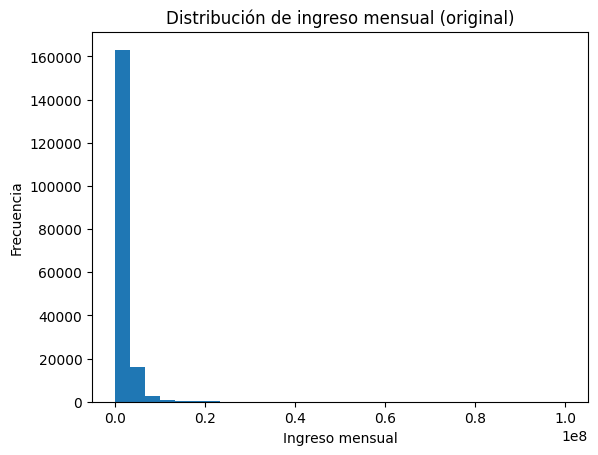

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_anual['ingreso_mensual'].dropna(), bins=30)
plt.title('Distribución de ingreso mensual (original)')
plt.xlabel('Ingreso mensual')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
plt.figure()
plt.hist(df_anual['log_ingreso'].dropna(), bins=30)
plt.title('Distribución de ingreso mensual (log1p)')
plt.xlabel('log(ingreso_mensual + 1)')
plt.ylabel('Frecuencia')
plt.show()

KeyError: 'log_ingreso'

<Figure size 640x480 with 0 Axes>

In [ ]:
desc2 = df_cont[["ingreso_capped","log_ingreso","edad","antiguedad_empresa_meses"]].describe().T
desc2["skewness"] = df_cont.skew()
desc2["kurtosis"] = df_cont.kurt()
display(desc2)

KeyError: "['antiguedad_empresa_meses'] not in index"

In [ ]:
plt.figure()
plt.boxplot([df_anual['ingreso_mensual'].dropna(), df_anual['log_ingreso'].dropna()],
            labels=['Original', 'Log1p'])
plt.title('Boxplot: ingreso_mensual vs. log_ingreso')
plt.ylabel('Valor')
plt.show()


KeyError: 'log_ingreso'

<Figure size 640x480 with 0 Axes>

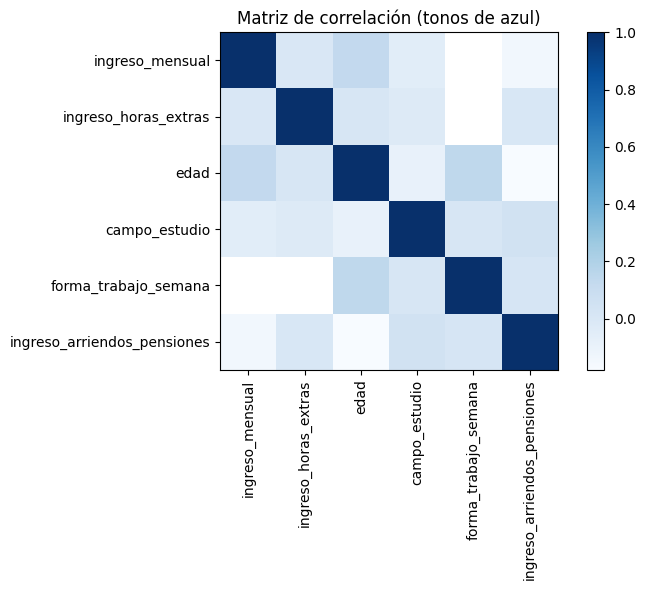

In [ ]:

corr = df_anual.select_dtypes(include=['int64','float64']).corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr, cmap='Blues', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(range(len(corr)))
ax.set_yticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
ax.set_title('Matriz de correlación (tonos de azul)')
plt.tight_layout()
plt.show()

In [ ]:
Q1 = df_anual['ingreso_mensual'].quantile(0.25)
Q3 = df_anual['ingreso_mensual'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQRs
upper = Q3 + 1.5 * IQR

outliers = df_anual[
    (df_anual['ingreso_mensual'] < lower) |
    (df_anual['ingreso_mensual'] > upper)
]
print(f"Número de outliers por IQR: {outliers.shape[0]}")


Número de outliers por IQR: 22677


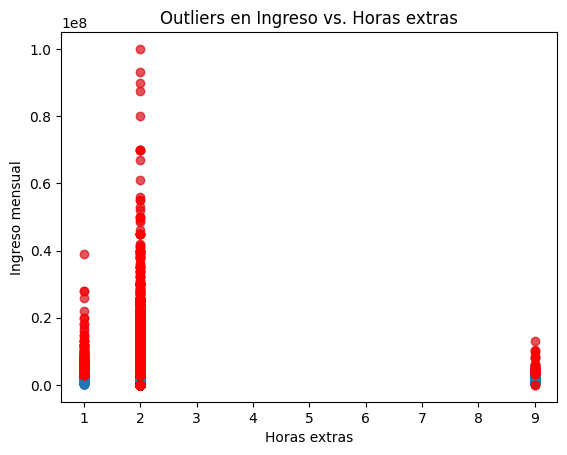

In [ ]:
plt.scatter(df_anual['ingreso_horas_extras'], df_anual['ingreso_mensual'], alpha=0.3)
plt.scatter(outliers['ingreso_horas_extras'], outliers['ingreso_mensual'], color='red', alpha=0.6)
plt.xlabel('Horas extras')
plt.ylabel('Ingreso mensual')
plt.title('Outliers en Ingreso vs. Horas extras')
plt.show()